In [1]:
from pyscal.core import System
from pyscal.crystal_structures import Structure
from pyscal_rdf.json_io import write_file
from pyscal_rdf.rdfutils import convert_to_dict
from pyscal_rdf.visualize import visualize_graph

Update hedgedoc [here](https://iffmd.fz-juelich.de/BRIkKGLlQduS8dA0sXKoZw)

## Creating structure from pyscal

In [2]:
struct = Structure()

In [3]:
sys = struct.lattice.l12(element=['Al', 'Ni'], 
                         lattice_constant=3)

['Al', 'Ni']


In [4]:
sysdict = convert_to_dict(sys)

In [5]:
write_file("structure.json", sysdict)

## RDFLIB Mapping

Assuming one structure dictionary

In [6]:
from rdflib import Graph, Literal, Namespace, XSD, RDF, RDFS, BNode, URIRef, FOAF, SKOS

In [7]:
CMSO = Namespace("https://purls.helmholtz-metadaten.de/cmso/")

In [8]:
g = Graph()
sample = BNode('Sample')
g.add((sample, RDF.type, CMSO.AtomicScaleSample))
#g.add((sample, SKOS.altLabel, Literal("A")))

material = BNode('Material')
g.add((sample, CMSO.hasMaterial, material))
g.add((material, RDF.type, CMSO.CrystallineMaterial))
#g.add(())

<Graph identifier=Na0e9f3598f33423eb24296e80606f12f (<class 'rdflib.graph.Graph'>)>

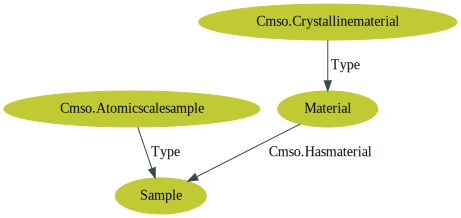

In [11]:
visualize_graph(g, node_color="#c0ca33", shape="ellipse")

In [ ]:
Coordinate_Vector = URIRef("https://w3id.org/mdo/structure/CoordinateVector")
Lattice = URIRef("https://purls.helmholtz-metadaten.de/disos/cso#Lattice")
Structure

In [ ]:

g.add((Coordinate_Vector, MDO.X_axisCoordinate, Literal(data["X_AxisCoordinate"])))
g.add((Coordinate_Vector, MDO.Y_axisCoordinate, Literal(data["Y_AxisCoordinate"])))
g.add((Coordinate_Vector, MDO.Z_axisCoordinate, Literal(data["Z_AxisCoordinate"])))

In [ ]:
with open("dump-ld.json", "w") as fout:
    fout.write(g.serialize(format="json-ld"))

In [ ]:
print(g.serialize(format="json-ld"))

- Map the terms (see above)
- Terms for type annotations
- Use BNode to add multiple structures
- Add visualisation
- Space group calculation
- try saving to database
- Query the graph (range queries possible?)
- Make a package out of it
- Extend....

## Examples

### POSCAR

In [4]:
sys = System("al_data/Al.poscar", format="poscar")

In [5]:
convert_to_dict(sys)
write_file("dump", convert_to_dict(sys))

In [6]:
sys.composition

{'Al': 1.0}

### LAMMPS - dump

In [7]:
sys = System("al_data/Al.dump")

In [8]:
convert_to_dict(sys)
write_file("dump2", convert_to_dict(sys))

In [9]:
sys.composition

{1: 1.0}

### CIF/ ASE

In [7]:
from ase.io import read

In [8]:
aseobj = read("al_data/Al.cif", format="cif")

In [9]:
sys = System(aseobj, format="ase")

In [10]:
convert_to_dict(sys)
write_file("dump3", convert_to_dict(sys))

In [11]:
data = convert_to_dict(sys)